# **<span style="color: RED;">CHUẨN BỊ THƯ VIỆN CẦN THIẾT</span>**

In [47]:
%pip install opencv-python numpy matplotlib scikit-image pandas seaborn


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\ASUS ROG STRIX\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


# **<span style="color: RED;">IMPORT THƯ VIỆN</span>**

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import seaborn as sns
import os
import time
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (15, 10)


# **<span style="color: RED;">ĐỊNH NGHĨA CÁC HÀM XỬ LÍ ẢNH</span>**

Việc thêm nhiễu Gaussian trong phần code hướng dẫn là một bước mở rộng phổ biến trong thực nghiệm xử lý ảnh, nhằm:

Tạo môi trường thử thách cho các bộ lọc: giúp kiểm tra khả năng giảm nhiễu, phục hồi chi tiết của từng bộ lọc trong điều kiện ảnh bị nhiễu.

Dễ dàng nhận ra sự khác biệt về hiệu quả giữa các bộ lọc, nhất là khi ảnh gốc quá sạch thì kết quả lọc sẽ không rõ ràng.

In [49]:
def safe_kernel_size(k):
    return k if k % 2 == 1 else k + 1

def apply_mean_filter(image, kernel_size=5):
    kernel_size = safe_kernel_size(kernel_size)
    start = time.time()
    result = cv2.blur(image, (kernel_size, kernel_size))
    elapsed = time.time() - start
    return result, elapsed

def apply_gaussian_filter(image, kernel_size=5, sigma=1.0):
    kernel_size = safe_kernel_size(kernel_size)
    start = time.time()
    result = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
    elapsed = time.time() - start
    return result, elapsed

def apply_bilateral_filter(image, d=9, sigma_color=75, sigma_space=75):
    start = time.time()
    result = cv2.bilateralFilter(image, d, sigma_color, sigma_space)
    elapsed = time.time() - start
    return result, elapsed

def calculate_psnr(original, processed):
    return psnr(original, processed, data_range=255)

def calculate_ssim(original, processed):
    if len(original.shape) == 3:
        return ssim(original, processed, channel_axis=2, data_range=255)
    else:
        return ssim(original, processed, data_range=255)

def calculate_mse(original, processed):
    return np.mean((original - processed) ** 2)

def add_gaussian_noise(image, mean=0, var=0.01):
    row, col, ch = image.shape
    gauss = np.random.normal(mean, var**0.5, (row, col, ch))
    noisy = image + gauss * 255
    return np.clip(noisy, 0, 255).astype(np.uint8)

def show_all_images(img, noisy, mean, gauss, bilateral):
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Ảnh gốc', fontsize=14, fontweight='bold')
    axes[0, 1].imshow(cv2.cvtColor(noisy, cv2.COLOR_BGR2RGB))
    axes[0, 1].set_title('Nhiễu Gaussian', fontsize=14)
    axes[0, 2].axis('off')
    axes[1, 0].imshow(cv2.cvtColor(mean, cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title('Mean Filter', fontsize=14)
    axes[1, 1].imshow(cv2.cvtColor(gauss, cv2.COLOR_BGR2RGB))
    axes[1, 1].set_title('Gaussian Filter', fontsize=14)
    axes[1, 2].imshow(cv2.cvtColor(bilateral, cv2.COLOR_BGR2RGB))
    axes[1, 2].set_title('Bilateral Filter', fontsize=14)
    for ax in axes.flat:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# **<span style="color: RED;">TẠO HOẶC LOAD ẢNH</span>**

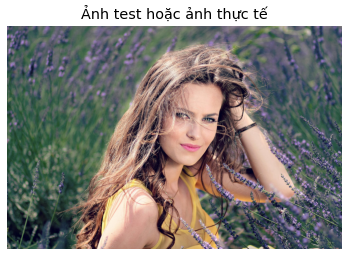

In [50]:
# Thay đường dẫn ảnh thực tế nếu muốn
img_path = 'images/mau.jpg'
img = cv2.imread(img_path)

if img is None:
    print("Không thể đọc ảnh, tạo ảnh test mẫu...")
    img = np.zeros((300, 300, 3), dtype=np.uint8)
    cv2.rectangle(img, (50, 50), (150, 150), (255, 100, 100), -1)
    cv2.circle(img, (200, 200), 50, (100, 255, 100), -1)
    cv2.line(img, (0, 0), (300, 300), (100, 100, 255), 5)
    cv2.putText(img, 'TEST', (100, 250), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Ảnh test hoặc ảnh thực tế')
plt.axis('off')
plt.show()


# **<span style="color: RED;">THÍ NGHIỆM CHÍNH</span>**

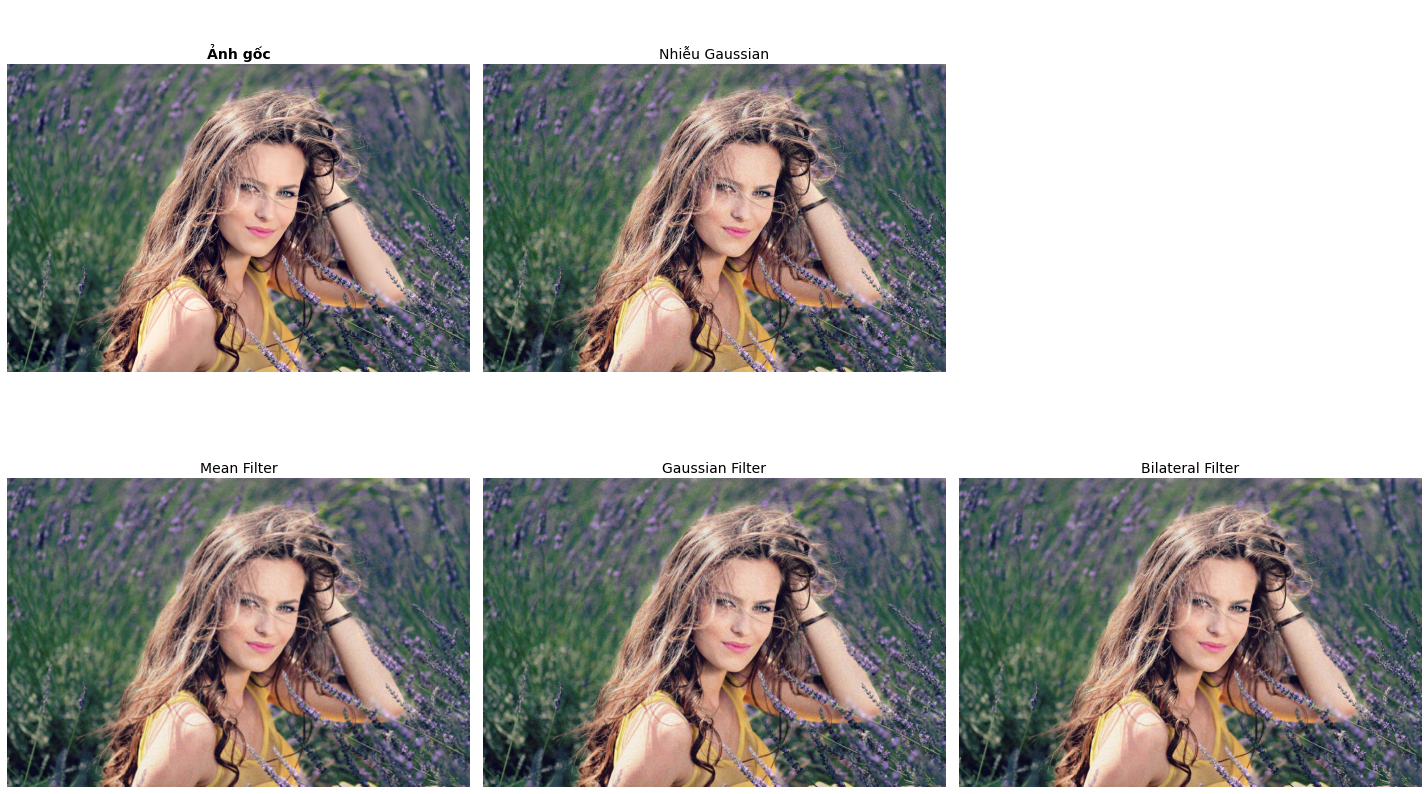

Đã lưu thành công các ảnh vào thư mục 'images_output'!


In [51]:
# Thêm nhiễu Gaussian (có thể bỏ nếu không cần)
noisy_gaussian = add_gaussian_noise(img, mean=0, var=0.01)

# Áp dụng các bộ lọc và đo thời gian
mean_filtered, t_mean = apply_mean_filter(noisy_gaussian, kernel_size=5)
gaussian_filtered, t_gauss = apply_gaussian_filter(noisy_gaussian, kernel_size=5, sigma=1.0)
bilateral_filtered, t_bilateral = apply_bilateral_filter(noisy_gaussian, d=9, sigma_color=75, sigma_space=75)

# Hiển thị tất cả ảnh
show_all_images(img, noisy_gaussian, mean_filtered, gaussian_filtered, bilateral_filtered)

# Lưu ảnh kết quả
output_dir = 'images_output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
cv2.imwrite(os.path.join(output_dir, 'original.jpg'), img)
cv2.imwrite(os.path.join(output_dir, 'noisy_gaussian.jpg'), noisy_gaussian)
cv2.imwrite(os.path.join(output_dir, 'mean_filtered.jpg'), mean_filtered)
cv2.imwrite(os.path.join(output_dir, 'gaussian_filtered.jpg'), gaussian_filtered)
cv2.imwrite(os.path.join(output_dir, 'bilateral_filtered.jpg'), bilateral_filtered)
print("Đã lưu thành công các ảnh vào thư mục 'images_output'!")


# **<span style="color: RED;">ĐÁNH GIÁ ĐỊNH LƯỢNG</span>**

In [52]:
# Đánh giá các chỉ số và thời gian xử lý
results = {
    'Noisy': {
        'PSNR': calculate_psnr(img, noisy_gaussian),
        'SSIM': calculate_ssim(img, noisy_gaussian),
        'MSE': calculate_mse(img, noisy_gaussian),
        'Time (s)': 0
    },
    'Mean Filter': {
        'PSNR': calculate_psnr(img, mean_filtered),
        'SSIM': calculate_ssim(img, mean_filtered),
        'MSE': calculate_mse(img, mean_filtered),
        'Time (s)': t_mean
    },
    'Gaussian Filter': {
        'PSNR': calculate_psnr(img, gaussian_filtered),
        'SSIM': calculate_ssim(img, gaussian_filtered),
        'MSE': calculate_mse(img, gaussian_filtered),
        'Time (s)': t_gauss
    },
    'Bilateral Filter': {
        'PSNR': calculate_psnr(img, bilateral_filtered),
        'SSIM': calculate_ssim(img, bilateral_filtered),
        'MSE': calculate_mse(img, bilateral_filtered),
        'Time (s)': t_bilateral
    }
}

df = pd.DataFrame(results).T
display(df)


,PSNR,SSIM,MSE,Time (s)
Noisy,20.180003,0.330113,93.417901,0.000000
Mean Filter,23.793840,0.695066,48.450313,0.008000
Gaussian Filter,25.161127,0.679656,56.591925,0.001018
Bilateral Filter,28.179919,0.722009,54.101966,0.026996


# **<span style="color: RED;">VẼ BIỂU ĐỒ SO SÁNH</span>**

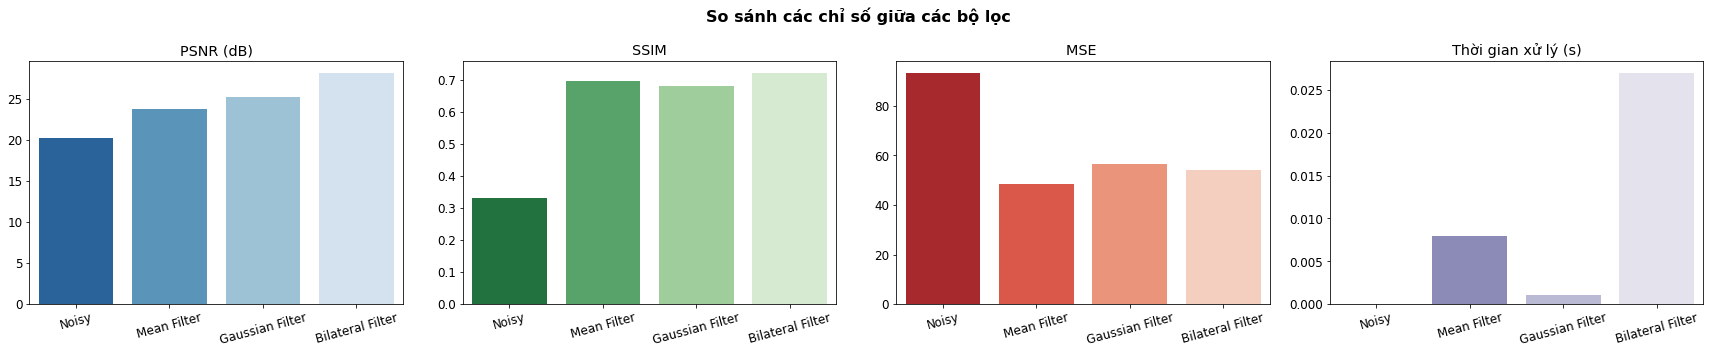

In [53]:
fig, axes = plt.subplots(1, 4, figsize=(24,5))
sns.barplot(x=df.index, y='PSNR', data=df, ax=axes[0], palette='Blues_r')
axes[0].set_title('PSNR (dB)')
sns.barplot(x=df.index, y='SSIM', data=df, ax=axes[1], palette='Greens_r')
axes[1].set_title('SSIM')
sns.barplot(x=df.index, y='MSE', data=df, ax=axes[2], palette='Reds_r')
axes[2].set_title('MSE ')
sns.barplot(x=df.index, y='Time (s)', data=df, ax=axes[3], palette='Purples_r')
axes[3].set_title('Thời gian xử lý (s)')
for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=15)
plt.suptitle('So sánh các chỉ số giữa các bộ lọc', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


# **<span style="color: RED;">PHÂN TÍCH BẢO TOÀN CẠNH (EDGE PRESERVATION)</span>**

In [54]:
def edge_preservation_score(img1, img2):
    # Chuyển sang grayscale và phát hiện cạnh bằng Canny
    edge1 = cv2.Canny(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), 50, 150)
    edge2 = cv2.Canny(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), 50, 150)
    return ssim(edge1, edge2, data_range=255)

edge_scores = {
    'Noisy': edge_preservation_score(img, noisy_gaussian),
    'Mean Filter': edge_preservation_score(img, mean_filtered),
    'Gaussian Filter': edge_preservation_score(img, gaussian_filtered),
    'Bilateral Filter': edge_preservation_score(img, bilateral_filtered)
}
print("Chỉ số bảo toàn cạnh (SSIM trên ảnh cạnh):")
for k, v in edge_scores.items():
    print(f"{k}: {v:.4f}")


Chỉ số bảo toàn cạnh (SSIM trên ảnh cạnh):
Noisy: 0.1398
Mean Filter: 0.6107
Gaussian Filter: 0.6995
Bilateral Filter: 0.7274


# **<span style="color: RED;">XUẤT KẾT QUẢ RA FILE CSV</span>**

In [55]:
df['Edge SSIM'] = [edge_scores[k] for k in df.index]
df.to_csv(os.path.join( 'metrics_comparison.csv'))
print("Đã lưu bảng kết quả metrics_comparison.csv vào images_output!")


Đã lưu bảng kết quả metrics_comparison.csv vào images_output!
